# Análisis de datos agrícolas

Se analizan datos de los 4 cultivos principales de la Argentina: soja, girasol, trigo y maíz.

In [46]:
import pandas as pd
import requests
import json
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.style.use("ggplot")

## 1. Conseguir los datos

### Portal de Datos Abiertos de Agroindustria 

Descargamos datos de producción, rendimiento, superficie sembrada y cosechada de los 4 cultivos desde el Portal de **Datos Abiertos de Agroindustria**: https://datos.magyp.gob.ar 

El archivo `datos/datos-magyp-cultivos-principales.csv` es una descarga de https://datos.magyp.gob.ar/reportes.php?reporte=Estimaciones eligiendo Soja, Girasol, Trigo y Maíz, a nivel de Departamentos (agregación geográfica).

In [6]:
df_cultivos = pd.read_csv("data/datos-magyp-cultivos-principales.csv", 
                          sep=";", encoding="latin1", thousands=".", decimal=",")

In [7]:
df_cultivos.head()

,Cultivo,Campaña,Provincia,Departamento,Sup. Sembrada,Sup. Cosechada,Producción,Rendimiento
0,Girasol,1969/70,BUENOS AIRES,25 de Mayo,30000,30000,22500,750
1,Girasol,1970/71,BUENOS AIRES,25 de Mayo,44000,31000,15000,484
2,Girasol,1971/72,BUENOS AIRES,25 de Mayo,22000,19000,10450,550
3,Girasol,1972/73,BUENOS AIRES,25 de Mayo,20000,5000,5100,1020
4,Girasol,1973/74,BUENOS AIRES,25 de Mayo,14000,14000,10800,771


In [8]:
a = df_cultivos["Sup. Cosechada"] <= df_cultivos["Sup. Sembrada"]

In [9]:
df_cultivos[~a]

,Cultivo,Campaña,Provincia,Departamento,Sup. Sembrada,Sup. Cosechada,Producción,Rendimiento
25680,Soja,2013/14,BUENOS AIRES,General Juan Madariaga,2050,19250,54975,2856
34843,Trigo,2014/15,BUENOS AIRES,Carlos Tejedor,25500,25550,71580,2802


El archivo `datos/datos-magyp-produccion-estimaciones.csv` es una descarga del dataset completo de estimaciones de producción primaria https://datos.magyp.gob.ar/reportes.php?reporte=Estimaciones (abajo de todo, "Descargar Dataset").

In [10]:
df_prod = pd.read_csv("data/datos-magyp-produccion-estimaciones.csv",
                     sep=";", encoding="latin1", thousands=".", decimal=",")

In [11]:
df_prod.head()

,ID Provincia,Provincia,ID Departamento,Departamento,Id Cultivo,Cultivo,ID Campaña,Campana,Sup. Sembrada (Ha),Sup. Cosechada (Ha),Producción (Tn),Rendimiento (Kg/Ha)
0,6,BUENOS AIRES,854,25 de Mayo,1,Ajo,1,1969/70,3,3,10,3333
1,6,BUENOS AIRES,854,25 de Mayo,1,Ajo,2,1970/71,1,1,3,3000
2,6,BUENOS AIRES,14,Adolfo Gonzales Chaves,1,Ajo,1,1969/70,15,15,82,5467
3,6,BUENOS AIRES,14,Adolfo Gonzales Chaves,1,Ajo,2,1970/71,10,10,55,5500
4,6,BUENOS AIRES,14,Adolfo Gonzales Chaves,1,Ajo,3,1971/72,8,8,44,5500


### COMTRADE

Queremos sumar datos de precios internacionales de estos 4 cultivos a lo largo del tiempo. Usamos la API de Comtrade (https://comtrade.un.org/data/doc/api) para descargar montos y cantidades totales exportadas en el mundo de cada uno y construir un precio promedio por tonelada exportada.

Nota: esta metodología tiene sus más y sus menos, para ver una discusión en mayor detalle sobre el tema ver el jupyter auxiliar **Precios internacionales de cultivos (COMTRADE vs. WB)**.

In [12]:
API_COMTRADE = "http://comtrade.un.org/api/get"

In [13]:
params = {
    "freq": "A", # frecuencia anual
    "r": 32, # reporter (reporta los datos): 32 es el código de la Argentina
    "ps": "ALL", # período (any para tomar todos los años)
    "px": "S1", # sistema de clasificación de productos: SITC Rev 1 es la serie más larga
    "fmt": "JSON", # formato devuelto (CSV o JSON)
    "p": 0, # partner (contraparte comercial del reporter): 0 es el código del Mundo
    "rg": 2, # 1: importaciones, 2: exportaciones
    "cc": "2214,041,4216,044", # commodity code: 2214 "Soya" / 041 "Wheat" / 4216 "Sunflower" / 044 "Corn"
    "max": 50000, # cantidad máxima de resultados (50.000 es un máximo absoluto)
    "head": "H", # M: machine readable headers, H: human readable headers
}

In [14]:
# si internet funciona
# res = requests.get(API_COMTRADE, params=params)
# json_res = res.json()

# si internet no funciona
with open("data/comtrade-cultivos-principales.json", "rb") as f:
    json_res = json.load(f)

In [15]:
df_comtrade = pd.DataFrame(json_res["dataset"])

In [16]:
df_comtrade.head(3)

,AltQuantity,CIFValue,FOBValue,GrossWeight,IsLeaf,NetWeight,TradeQuantity,TradeValue,aggrLevel,cmdCode,...,qtAltCode,qtAltDesc,qtCode,qtDesc,rgCode,rgDesc,rt3ISO,rtCode,rtTitle,yr
0,None,None,None,None,0,2832336128,2832336128,173363088,3,041,...,None,,8,Weight in kilograms,2,Export,ARG,32,Argentina,1962
1,None,None,None,None,0,1830655616,1830655616,116388784,3,041,...,None,,8,Weight in kilograms,2,Export,ARG,32,Argentina,1963
2,None,None,None,None,0,3710008576,3710008576,242256288,3,041,...,None,,8,Weight in kilograms,2,Export,ARG,32,Argentina,1964


In [17]:
df_comtrade.head(3).transpose()

,0,1,2
AltQuantity,None,None,None
CIFValue,None,None,None
FOBValue,None,None,None
GrossWeight,None,None,None
IsLeaf,0,0,0
NetWeight,2832336128,1830655616,3710008576
TradeQuantity,2832336128,1830655616,3710008576
TradeValue,173363088,116388784,242256288
aggrLevel,3,3,3
cmdCode,041,041,041


In [18]:
# TODO: comentar en español al lado de cada campo qué es
columns = ["rgDesc", "rtTitle", "ptTitle", "yr",
           "cmdCode", "cmdDescE", "TradeValue", "TradeQuantity", "qtDesc"]

In [19]:
df_comtrade[columns].head(5)

,rgDesc,rtTitle,ptTitle,yr,cmdCode,cmdDescE,TradeValue,TradeQuantity,qtDesc
0,Export,Argentina,World,1962,041,"Wheat including spelt and meslin, unmilled",173363088,2832336128,Weight in kilograms
1,Export,Argentina,World,1963,041,"Wheat including spelt and meslin, unmilled",116388784,1830655616,Weight in kilograms
2,Export,Argentina,World,1964,041,"Wheat including spelt and meslin, unmilled",242256288,3710008576,Weight in kilograms
3,Export,Argentina,World,1965,041,"Wheat including spelt and meslin, unmilled",372666400,6660583936,Weight in kilograms
4,Export,Argentina,World,1966,041,"Wheat including spelt and meslin, unmilled",279624704,5054666240,Weight in kilograms


In [20]:
df_comtrade[columns].tail(5)

,rgDesc,rtTitle,ptTitle,yr,cmdCode,cmdDescE,TradeValue,TradeQuantity,qtDesc
202,Export,Argentina,World,2011,4216,Sunflower seed oil,1176553428,908109965,Weight in kilograms
203,Export,Argentina,World,2012,4216,Sunflower seed oil,928531664,790948144,Weight in kilograms
204,Export,Argentina,World,2013,4216,Sunflower seed oil,528181934,447704974,Weight in kilograms
205,Export,Argentina,World,2014,4216,Sunflower seed oil,366774725,349370968,Weight in kilograms
206,Export,Argentina,World,2015,4216,Sunflower seed oil,405056803,439193748,Weight in kilograms


In [42]:
df_comtrade["precio_ton"] = df_comtrade.TradeValue / df_comtrade.TradeQuantity * 1000
df_precios = df_comtrade.pivot(index='yr',columns='cmdDescE',values='precio_ton')
df_precios.columns = ['Maiz', 'Soja', 'Girasol','Trigo']

In [22]:
precios_soja = df_comtrade[df_comtrade.cmdCode == "2214"][["yr", "precio_ton"]].sort_values("yr").set_index("yr")

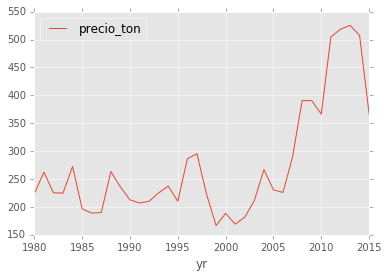

In [24]:
precios_soja[precios_soja.index >= 1980].plot.line()

In [25]:
precios_trigo = df_comtrade[df_comtrade.cmdCode == "041"][["yr", "precio_ton"]].sort_values("yr").set_index("yr")

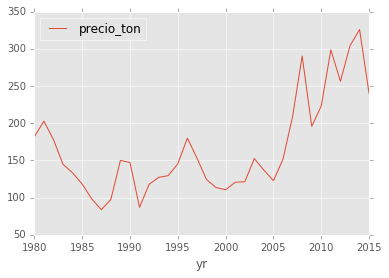

In [26]:
precios_trigo[precios_trigo.index >= 1980].plot.line()

In [27]:
precios_maiz = df_comtrade[df_comtrade.cmdCode == "044"][["yr", "precio_ton"]].sort_values("yr").set_index("yr")

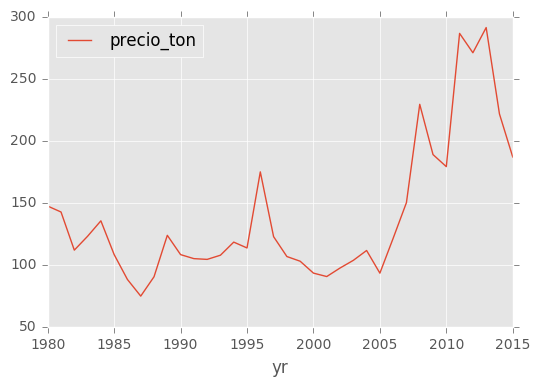

In [39]:
precios_maiz[precios_maiz.index >= 1980].plot.line()

In [40]:
precios_girasol = df_comtrade[df_comtrade.cmdCode == "4216"][["yr", "precio_ton"]].sort_values("yr").set_index("yr")

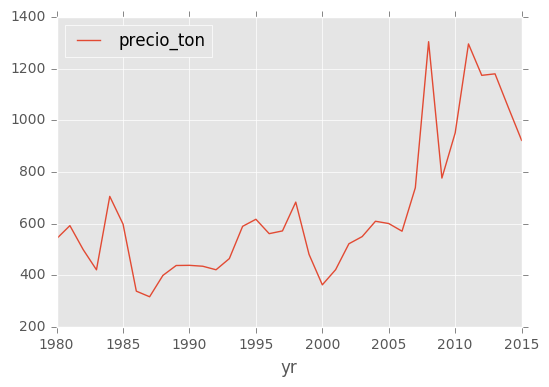

In [41]:
precios_girasol[precios_girasol.index >= 1980].plot.line()

## 2. Exploración inicial

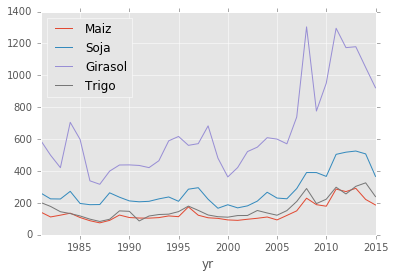

In [43]:
df_precios[df_precios.index>1980].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff74d998e90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff747778990>]], dtype=object)

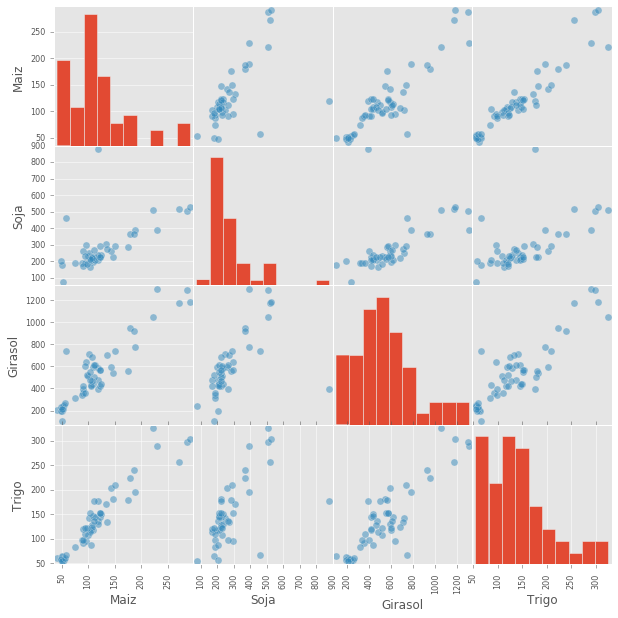

In [56]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(df_precios, figsize=(10,10), s=200)

## 3. Mapas

## 4. Inferencia estadística